In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from scipy.optimize import curve_fit

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():
    if subfolder.is_dir():
        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):  # Find all CSV files in the folder
            try:
                # Load each CSV file into a pandas dataframe
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=7)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}") # Skip to the next file if there's an error
                continue 

            # Add the folder/file name as columns to the dataframe for reference
            df['source_folder'] = subfolder.name
            # Add pretty name, replacing underscore with space
            df['source_folder_label'] = subfolder.name.replace('_', ' ')
            # Shorten csv file name to remove .csv suffix and RunX_ prefix
            df['source_file'] = csv_file.name[5:-4]
            # Add pretty name, replacing underscore with space
            df['source_file_label'] = csv_file.name[5:-4].replace('_', ' ')
            # Add linear Magnitude
            df['Linear Magnitude'] = 10**(df['Magnitude(dB)'] / 20.0)
            
            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

print(combined_df)

      Sample  Frequency(Hz)  Magnitude(dB)    Phase(°)       source_folder  \
0          0        50000.0        20.3973    0.147448            AD4898-1   
1          1        51586.1        20.2129   -0.104204            AD4898-1   
2          2        53222.5        20.2494   -0.472960            AD4898-1   
3          3        54910.8        20.2185   -0.290529            AD4898-1   
4          4        56652.7        20.2598   -1.058680            AD4898-1   
...      ...            ...            ...         ...                 ...   
7595     195      2136190.0       -13.1795 -257.000000  UA741_5Gain_20Gain   
7596     196      2221850.0       -13.4842 -267.000000  UA741_5Gain_20Gain   
7597     197      2310950.0       -12.5978 -235.000000  UA741_5Gain_20Gain   
7598     198      2403620.0       -14.4037 -270.000000  UA741_5Gain_20Gain   
7599     199      2500000.0       -14.8161 -274.000000  UA741_5Gain_20Gain   

     source_folder_label        source_file  source_file_label 

In [321]:
# Function to filter out input spikes
def remove_input_spike(df, threshold=1.5):
    clean_df = df.copy()
    
    # Loop through the first 10 rows and compare the current Magnitude with the next
    for i in range(min(10, len(clean_df) - 1)):
        current_magnitude = clean_df['Magnitude(dB)'].iloc[i]
        next_magnitude = clean_df['Magnitude(dB)'].iloc[i + 1]
        
        if current_magnitude > next_magnitude * threshold:
            clean_df = clean_df.drop(clean_df.index[i])
    
    return clean_df

In [322]:
# Function to filter plot data by source_folder and source_file, and optionally filter out input spikes
def select_data(df, source_folder, source_file, raw):
    # Filter by folder and file
    plot_data_raw = df[(df['source_folder'] == source_folder) & (df['source_file'] == source_file)]
    
    # Default to plotting raw data
    if raw:
        return plot_data_raw
    
    # Filter out input spike
    return remove_input_spike(plot_data_raw)

In [323]:
#Function for finding -3dB
def find_cutoff(df, samples_to_average):
    avg_dc_gain = np.mean(df['Magnitude(dB)'][:samples_to_average])
    minus_three_dB_point = (avg_dc_gain - 3.0)

    min_distance_from_three_db = sys.float_info.max
    min_idx = samples_to_average
    for i in range(samples_to_average, len(df) - 1):
        magnitude = df['Magnitude(dB)'].iloc[i]
        distance_from_three_db = abs(magnitude - minus_three_dB_point)
        
        if distance_from_three_db < min_distance_from_three_db:
            min_distance_from_three_db = distance_from_three_db
            min_idx = i

    frequency = df['Frequency(Hz)'].iloc[min_idx]
    magnitude = df['Magnitude(dB)'].iloc[min_idx]
    print(f'low point <{min_idx}> <{min_distance_from_three_db}> <{frequency}> <{magnitude}>')

    idx = next(x for x, val in enumerate(df['Magnitude(dB)']) if val < (avg_dc_gain - 2.99))
    old_frequency = df['Frequency(Hz)'].iloc[idx]
    old_magnitude = df['Magnitude(dB)'].iloc[idx]
    print(f'low point <{idx}> <{abs(old_magnitude - minus_three_dB_point)}> <{old_frequency}> <{old_magnitude}>')
    return avg_dc_gain, frequency, magnitude


In [324]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]
    avg_dc_gain, frequency, magnitude = find_cutoff(plot_data, 50)
#    gbp1 = frequency * magnitude
#    gbp2 = frequency * avg_dc_gain
    gbp3 = frequency * 10**(magnitude / 20.0)

    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=plot_label)

    plt.axvline(x=frequency, color='r')
    plt.axhline(y=magnitude, color='r')

    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {plot_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    #plt.figtext(0.44, 0.2, f'Average DC gain = {avg_dc_gain:.2f} dB\n-3dB Magnitude = {magnitude:.2f} dB\nFrequency = {frequency:.2f} Hz\nGBP1 = {gbp1:.2f}\nGBP2 = {gbp2:.2f}\nGBP3 = {gbp3:.2f}', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.figtext(0.44, 0.2, f'Average DC gain = {avg_dc_gain:.2f} dB\n-3dB Magnitude = {magnitude:.2f} dB\nFrequency = {frequency:.2f} Hz\nGBP = {gbp3:.2f} Hz', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

#    plt.savefig(f'C:\\Users\\david\\Desktop\\Quantum\\PHYS4680\\Analog1\\Analog_Lab\\GraphsForTeamReport\\CutoffFrequencyFor{source_file}.png', bbox_inches='tight')
    plt.show()

In [325]:
# Plot Frequency (Hz) vs Phase (°)
def plot_frequency_vs_phase(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase(°)')
    plt.title(f'Frequency vs Phase for {plot_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [326]:
# Plot Frequency (Hz) vs Magnitude (dB), Phase (°)
def plot_frequency_vs_magnitude_phase(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]

    fig, ax1 = plt.subplots(layout='constrained')

    color = 'tab:blue'
    ax1.set_xlabel('Frequency (Hz) [log scale]')
    ax1.set_xscale('log')
    ax1.set_ylabel('Magnitude (dB)', color=color)
    ax1.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], color=color, label=plot_label)
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Phase(°)', color=color)  # we already handled the x-label with ax1
    ax2.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], color=color, label=plot_label)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Frequency vs Magnitude(dB) and Phase(°) for {plot_label}')
#    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

low point <133> <0.08638999999999797> <186632.0> <10.1013>
low point <134> <0.12243000000000137> <194115.0> <9.89248>


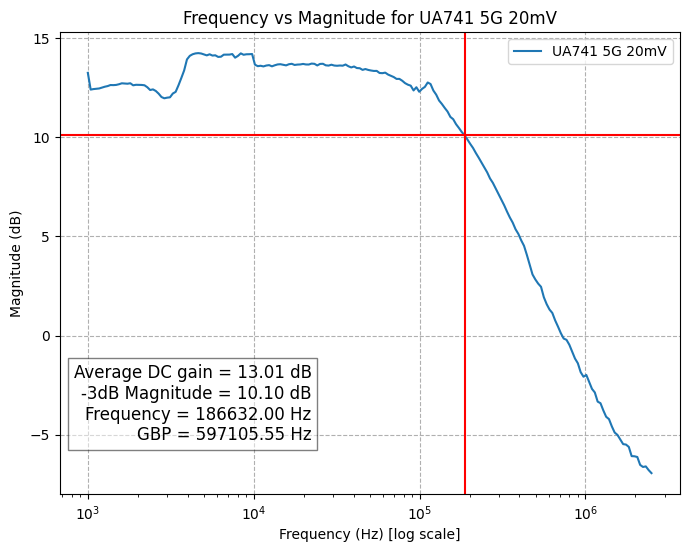

low point <129> <0.003133999999999304> <159472.0> <11.0582>
low point <129> <0.003133999999999304> <159472.0> <11.0582>


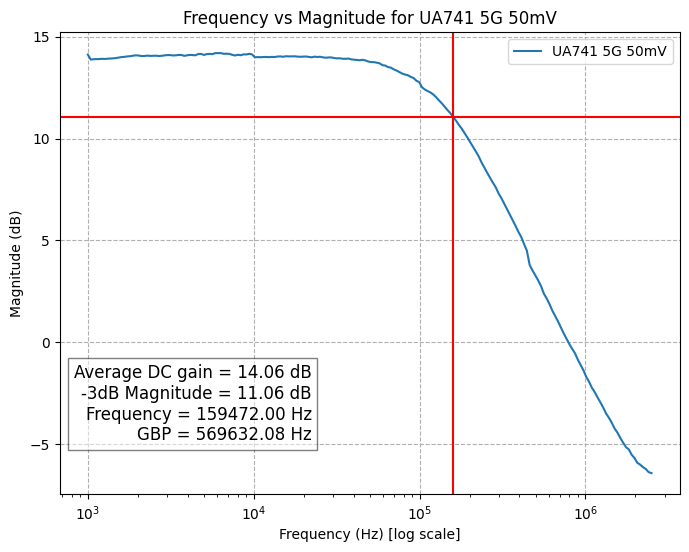

low point <128> <0.06181599999999854> <153324.0> <11.0111>
low point <129> <0.12478400000000178> <159472.0> <10.8245>


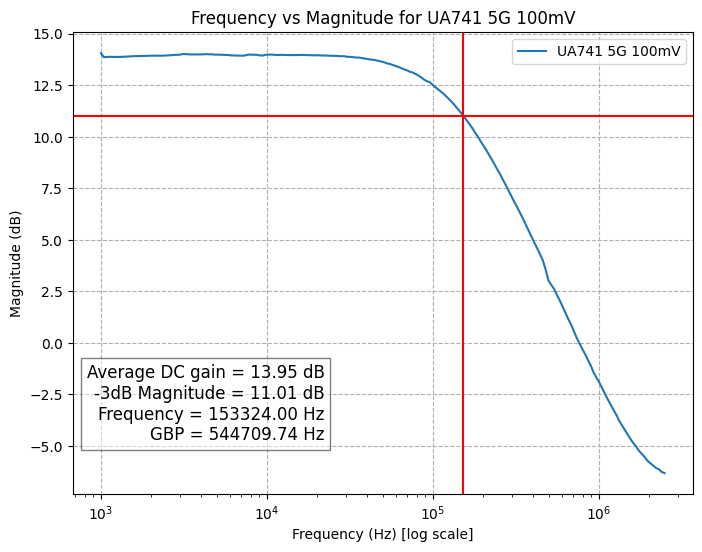

low point <112> <0.09121600000000285> <81735.1> <10.8326>
low point <112> <0.09121600000000285> <81735.1> <10.8326>


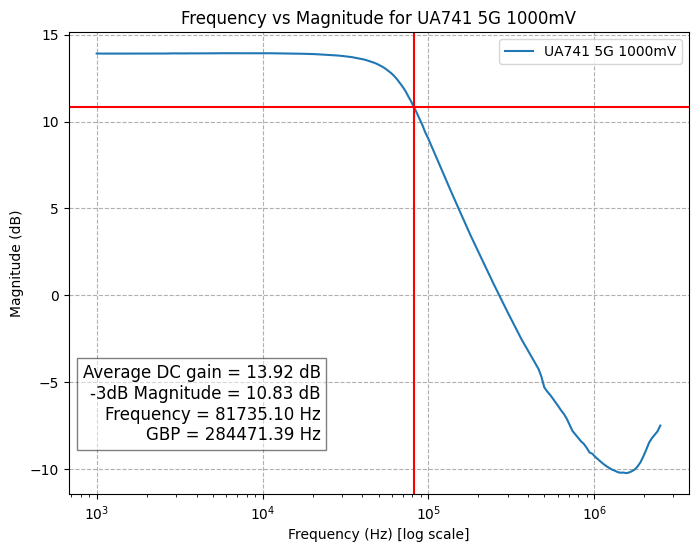

low point <104> <0.02363399999999949> <62070.2> <11.0106>
low point <104> <0.02363399999999949> <62070.2> <11.0106>


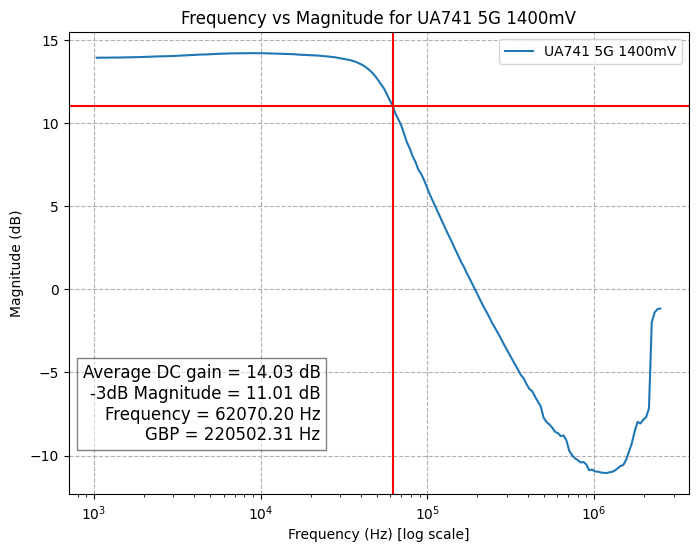

In [327]:
# Pick dataset
raw = False
#source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
#source_file_to_plot = 'UA741_5G_50mV'  # Replace with file name

# Call the plot functions for the specific folder and file
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)
#plot_frequency_vs_phase(combined_df, source_folder_to_plot, source_file_to_plot, raw)
#plot_frequency_vs_magnitude_phase(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_20mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_100mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_1000mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_1400mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain'  # Replace with folder name
source_file_to_plot = 'UA741_20G_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_100Gain'  # Replace with folder name
source_file_to_plot = 'UA741_100G_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'AD797'  # Replace with folder name
source_file_to_plot = 'AD797_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'AD848'  # Replace with folder name
source_file_to_plot = 'AD848_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'AD4898-1'  # Replace with folder name
source_file_to_plot = 'AD4898-1_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'LMH6624'  # Replace with folder name
source_file_to_plot = 'LMH6624_40mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain_20Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_20G_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_20G_5G_50mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)


In [328]:
# Plot Frequency (Hz) vs Magnitude (dB) for all files in a folder
def plot_all_files_magnitude(df, source_folder, raw):
    # Filter by EB folder
    folder_data = df[df['source_folder'] == source_folder]
    files_in_folder = folder_data['source_file'].unique()
    folder_label = folder_data['source_folder_label'].iloc[0]

    plt.figure(figsize=(8, 6))
    
    # Loop through each file and plot its data
    print('label\tcutoff_frequency\tmagnitude\tlinear_magnitude\tgbp')
    for source_file in files_in_folder:
        plot_data = select_data(df, source_folder, source_file, raw)
        plot_label = plot_data['source_file_label'].iloc[0]
        avg_dc_gain, frequency, magnitude = find_cutoff(plot_data, 50)
        linear_magnitude = 10**(magnitude / 20.0)
        gbp = frequency * linear_magnitude
        print(f'{plot_label}\t{frequency:.0f}\t{magnitude:.2f}\t{linear_magnitude:.2f}\t{gbp:.0f}')
#        print(f'{plot_label}\t{gbp3:.0f}')
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {folder_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()

#    plt.savefig(f'C:\\Users\\david\\Desktop\\Quantum\\PHYS4680\\Analog1\\Analog_Lab\\GraphsForTeamReport\\FrequencyVsMagnitudeFor{source_folder}.png', bbox_inches='tight')
    plt.show()

In [329]:
# Plot Frequency (Hz) vs Phase (°) for all files in a folder
def plot_all_files_phase(df, source_folder, raw):
    # Filter by EB folder
    folder_data = df[df['source_folder'] == source_folder]
    files_in_folder = folder_data['source_file'].unique()
    
    plt.figure(figsize=(8, 6))

    # Loop through each file and plot its data
    for source_file in files_in_folder:
        plot_data = select_data(df, source_folder, source_file, raw)
        plot_label = plot_data['source_file_label'].iloc[0]
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase (degree)')
    plt.title(f'Frequency vs Phase for {source_folder}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <133> <0.08638999999999797> <186632.0> <10.1013>
low point <134> <0.12243000000000137> <194115.0> <9.89248>
UA741 5G 20mV	186632	10.10	3.20	597106
low point <129> <0.003133999999999304> <159472.0> <11.0582>
low point <129> <0.003133999999999304> <159472.0> <11.0582>
UA741 5G 50mV	159472	11.06	3.57	569632
low point <128> <0.06181599999999854> <153324.0> <11.0111>
low point <129> <0.12478400000000178> <159472.0> <10.8245>
UA741 5G 100mV	153324	11.01	3.55	544710
low point <112> <0.09121600000000285> <81735.1> <10.8326>
low point <112> <0.09121600000000285> <81735.1> <10.8326>
UA741 5G 1000mV	81735	10.83	3.48	284471
low point <104> <0.02363399999999949> <62070.2> <11.0106>
low point <104> <0.02363399999999949> <62070.2> <11.0106>
UA741 5G 1400mV	62070	11.01	3.55	220502


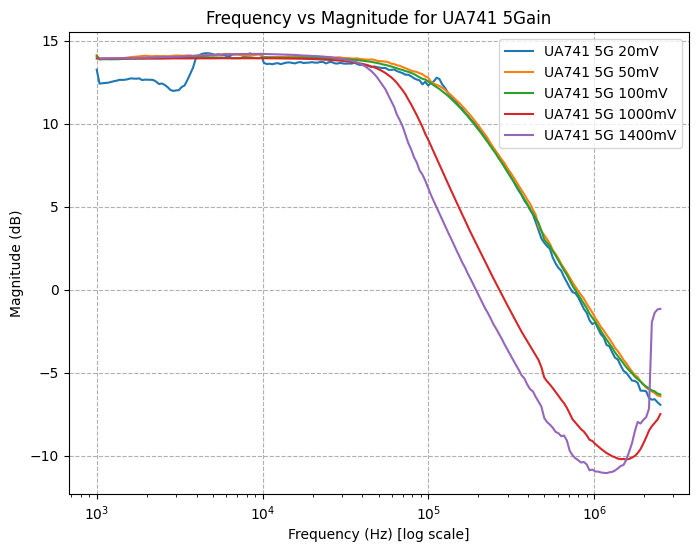

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <101> <0.06923399999999802> <53037.4> <22.0144>
low point <102> <0.16756600000000077> <55164.2> <21.7776>
UA741 20G 20mV	53037	22.01	12.61	668809
low point <98> <0.03267599999999504> <47136.5> <23.0301>
low point <98> <0.03267599999999504> <47136.5> <23.0301>
UA741 20G 50mV	47136	23.03	14.17	668132
low point <97> <0.038405999999998386> <45319.2> <22.9417>
low point <97> <0.038405999999998386> <45319.2> <22.9417>
UA741 20G 100mV	45319	22.94	14.03	635868
low point <96> <0.08361199999999869> <43572.0> <22.8616>
low point <96> <0.08361199999999869> <43572.0> <22.8616>
UA741 20G 200mV	43572	22.86	13.90	605742


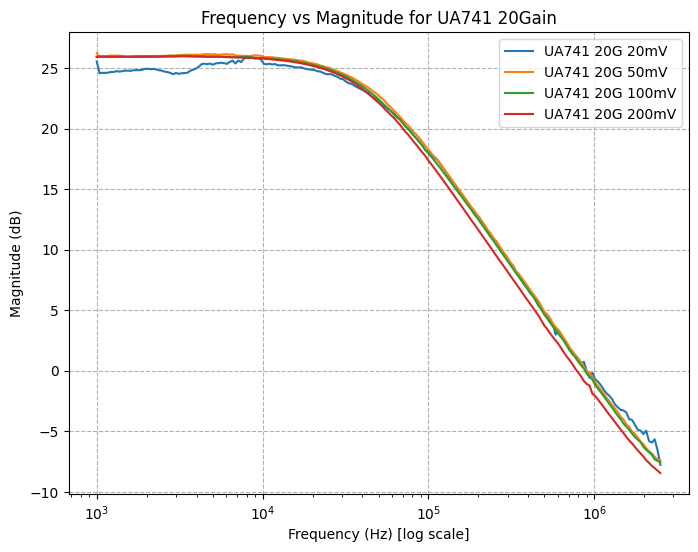

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <62> <0.09934200000000004> <11446.0> <35.6294>
low point <63> <0.10345799999999628> <11905.0> <35.4266>
UA741 100G 20mV	11446	35.63	60.46	692028
low point <61> <0.06369400000000525> <11004.7> <36.2068>
low point <61> <0.06369400000000525> <11004.7> <36.2068>
UA741 100G 40mV	11005	36.21	64.62	711080
low point <59> <0.08661400000000441> <10580.5> <36.6987>
low point <60> <0.1166860000000014> <11004.7> <36.4954>
UA741 100G 50mV	10580	36.70	68.38	723504
low point <59> <0.06808200000000397> <10580.5> <36.5068>
low point <59> <0.06808200000000397> <10580.5> <36.5068>
UA741 100G 60mV	10580	36.51	66.89	707695


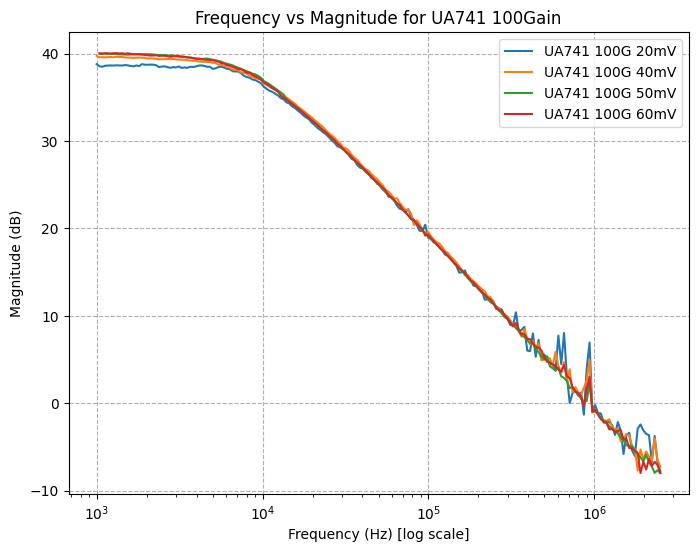

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <160> <0.08538599999999974> <7395990.0> <20.0288>
low point <160> <0.08538599999999974> <7395990.0> <20.0288>
AD797 20mV	7395990	20.03	10.03	74205538
low point <158> <0.03742400000000501> <6948180.0> <20.5081>
low point <158> <0.03742400000000501> <6948180.0> <20.5081>
AD797 40mV	6948180	20.51	10.60	73667522
low point <157> <0.09216400000000036> <6734540.0> <20.4369>
low point <158> <0.27973599999999976> <6948180.0> <20.065>
AD797 50mV	6734540	20.44	10.52	70819513
low point <146> <0.10506399999999516> <4776600.0> <20.474>
low point <147> <0.17173600000000633> <4928120.0> <20.1972>
AD797 100mV	4776600	20.47	10.56	50445087
low point <129> <0.013670000000001181> <2809010.0> <20.348>
low point <129> <0.013670000000001181> <2809010.0> <20.348>
AD797 200mV	2809010	20.35	10.41	29238379


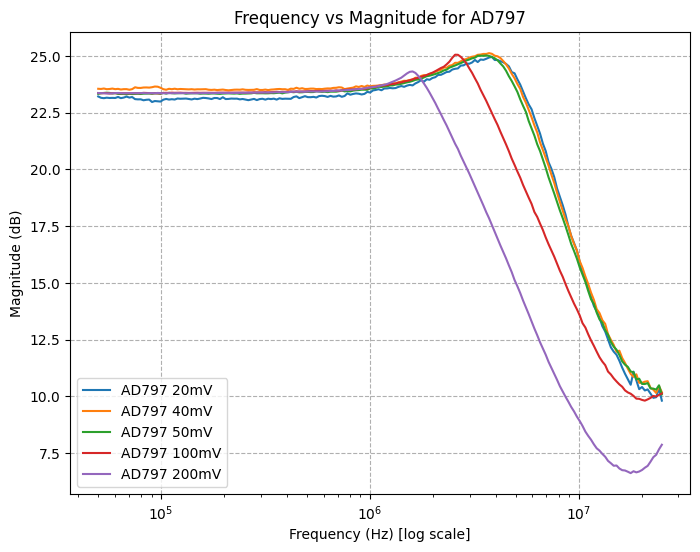

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <186> <0.026895999999997144> <16658100.0> <17.2321>
low point <187> <0.5245040000000003> <17186500.0> <16.6807>
AD848 20mV	16658100	17.23	7.27	121124073
low point <186> <0.038239999999998275> <16658100.0> <17.6935>
low point <187> <0.42856000000000094> <17186500.0> <17.2267>
AD848 40mV	16658100	17.69	7.67	127732221
low point <187> <0.1836999999999982> <17186500.0> <17.271>
low point <187> <0.1836999999999982> <17186500.0> <17.271>
AD848 50mV	17186500	17.27	7.30	125527085
low point <186> <0.008355999999999142> <16658100.0> <17.4941>
low point <186> <0.008355999999999142> <16658100.0> <17.4941>
AD848 100mV	16658100	17.49	7.49	124833304
low point <186> <0.12840000000000273> <16658100.0> <17.349>
low point <186> <0.12840000000000273> <16658100.0> <17.349>
AD848 200mV	16658100	17.35	7.37	122765253


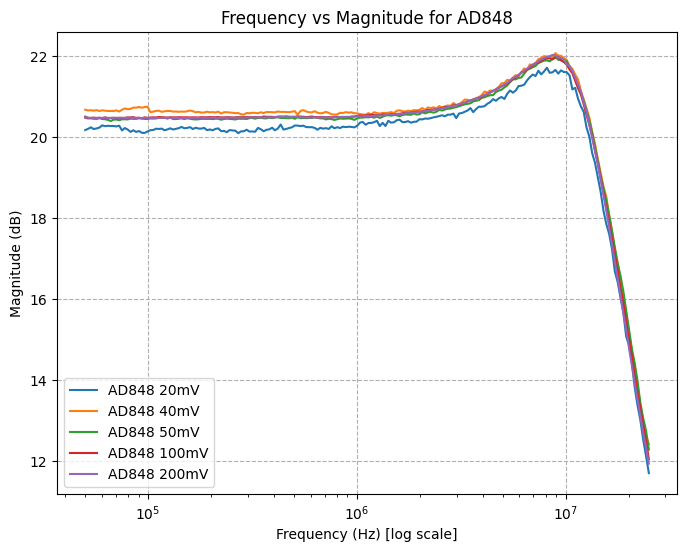

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <168> <0.1604360000000007> <9495050.0> <17.0361>
low point <168> <0.1604360000000007> <9495050.0> <17.0361>
AD4898-1 20mV	9495050	17.04	7.11	67499764
low point <167> <0.10730399999999918> <9203110.0> <17.7677>
low point <168> <0.17769600000000096> <9495050.0> <17.4827>
AD4898-1 40mV	9203110	17.77	7.73	71173711
low point <168> <0.09411199999999909> <9495050.0> <17.3568>
low point <168> <0.09411199999999909> <9495050.0> <17.3568>
AD4898-1 50mV	9495050	17.36	7.38	70038568
low point <167> <0.13565399999999528> <9203110.0> <17.3501>
low point <167> <0.13565399999999528> <9203110.0> <17.3501>
AD4898-1 100mV	9203110	17.35	7.37	67832779
low point <161> <0.015412000000001314> <7630600.0> <17.4624>
low point <161> <0.015412000000001314> <7630600.0> <17.4624>
AD4898-1 200mV	7630600	17.46	7.47	56974259


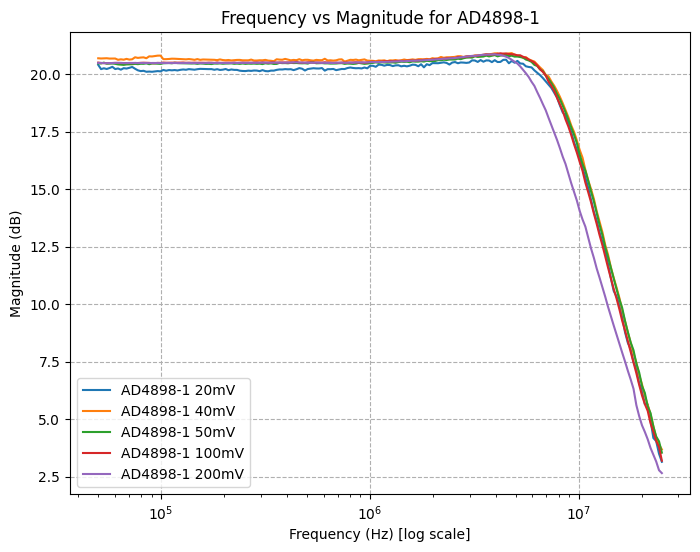

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <145> <0.017261999999995226> <4629740.0> <36.5748>
low point <145> <0.017261999999995226> <4629740.0> <36.5748>
LMH6624 20mV	4629740	36.57	67.41	312102036
low point <145> <0.08349000000000473> <4629740.0> <36.9182>
low point <145> <0.08349000000000473> <4629740.0> <36.9182>
LMH6624 40mV	4629740	36.92	70.13	324688272


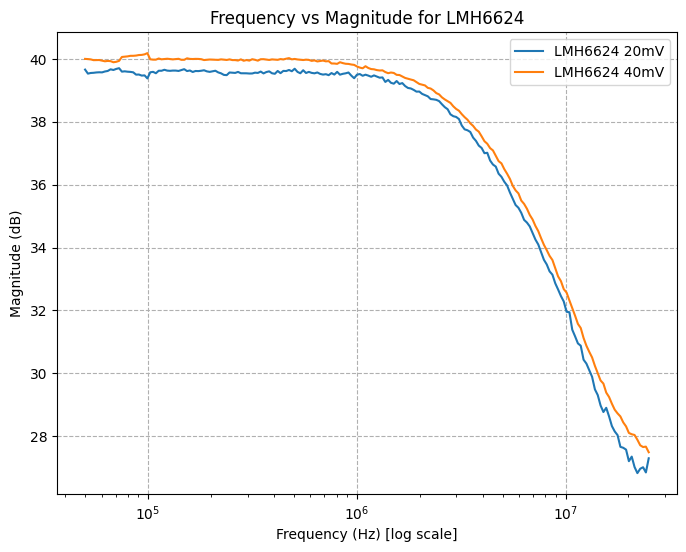

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <93> <0.06408800000000525> <38724.2> <35.747>
low point <94> <0.20481199999999689> <40277.0> <35.4781>
UA741 5G 20G 20mV	38724	35.75	61.28	2373190
low point <90> <0.03535800000000222> <35795.8> <36.8111>
low point <90> <0.03535800000000222> <35795.8> <36.8111>
UA741 5G 20G 40mV	35796	36.81	69.27	2479631
low point <89> <0.026636000000003435> <34415.7> <37.143>
low point <90> <0.1482639999999975> <35795.8> <36.9681>
UA741 5G 20G 50mV	34416	37.14	71.97	2476889
low point <88> <0.04263800000000373> <33088.9> <37.2607>
low point <89> <0.1245619999999974> <34415.7> <37.0935>
UA741 5G 20G 60mV	33089	37.26	72.95	2413889


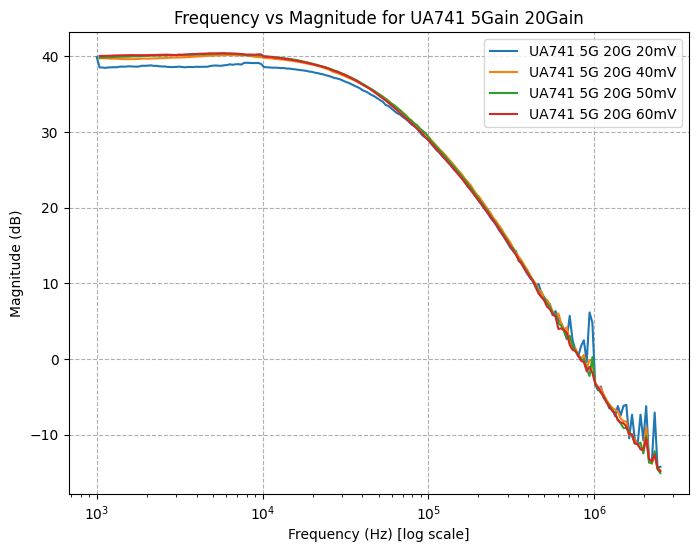

label	cutoff_frequency	magnitude	linear_magnitude	gbp
low point <86> <0.05862799999999879> <29407.4> <35.7387>
low point <87> <0.18827200000000488> <30586.6> <35.4918>
UA741 20G 5G 20mV	29407	35.74	61.23	1800494
low point <83> <0.03515999999999764> <27183.6> <36.8842>
low point <84> <0.1461400000000026> <28273.6> <36.7029>
UA741 20G 5G 40mV	27184	36.88	69.86	1898965
low point <83> <0.07018399999999758> <27183.6> <37.027>
low point <83> <0.07018399999999758> <27183.6> <37.027>
UA741 20G 5G 50mV	27184	37.03	71.01	1930443
low point <81> <0.055391999999997665> <25127.9> <37.2371>
low point <82> <0.1173080000000013> <26135.5> <37.0644>
UA741 20G 5G 60mV	25128	37.24	72.75	1828147


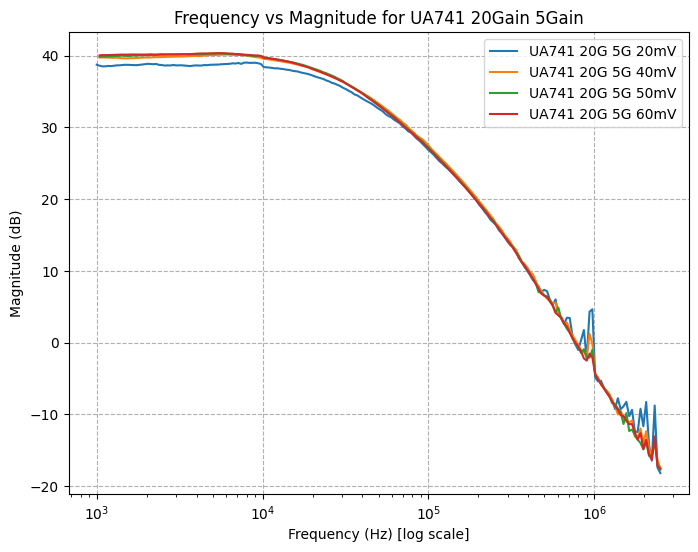

In [330]:
# Pick folder of EB's to plot
raw = False
source_folder_to_plot = 'UA741_5Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_100Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'AD797'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'AD848'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'AD4898-1'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'LMH6624'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain_20Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain_5Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

In [331]:
class FolderFile:
    def __init__(self, source_folder, source_file):
        self.source_folder = source_folder
        self.source_file = source_file

In [332]:
# Plot Frequency (Hz) vs Magnitude (dB) for selected files
def plot_file_magnitudes(df, folder_files, raw):
    plt.figure(figsize=(8, 6))
    
    # Loop through each file and plot its data
    for folder_file in folder_files:
        plot_data = select_data(df, folder_file.source_folder, folder_file.source_file, raw)
        plot_label = plot_data['source_file_label'].iloc[0]
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for selected op-amps')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [333]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {source_file}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

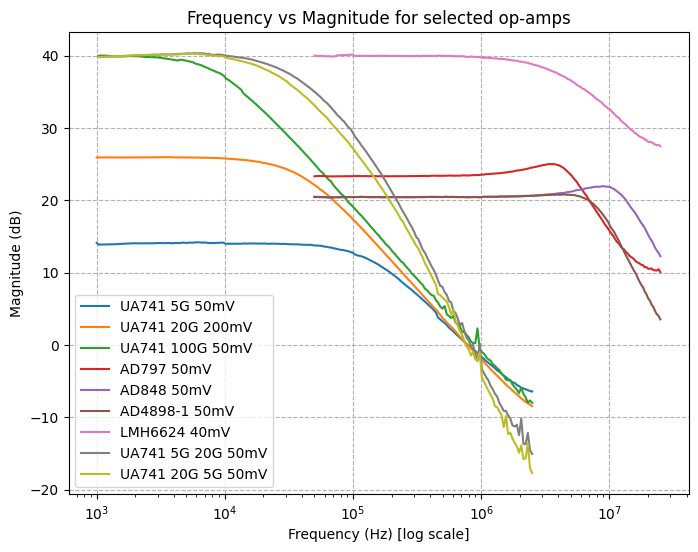

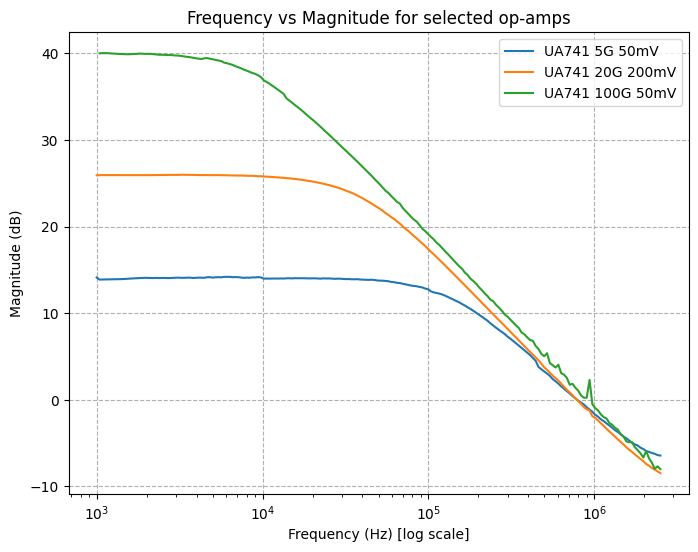

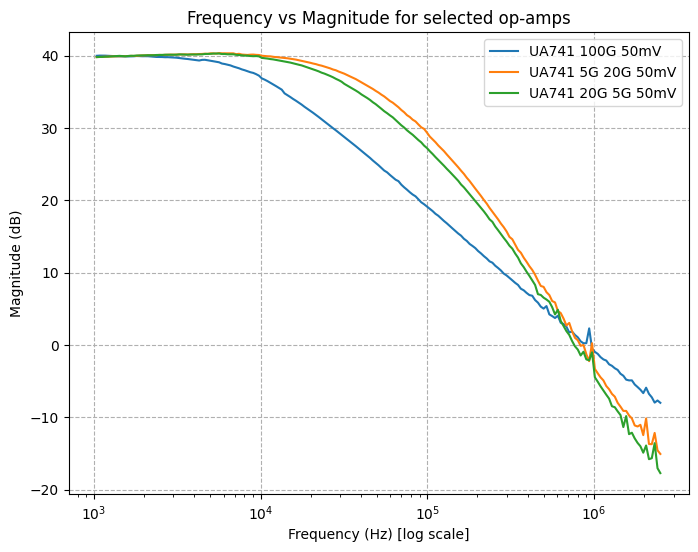

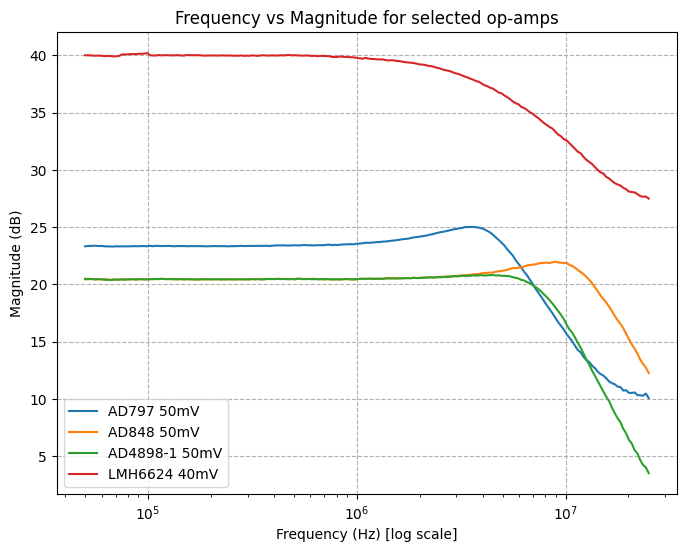

In [334]:
# Pick specific EB's and Inputs to plot
raw = False

plot_file_magnitudes(combined_df, [
    FolderFile('UA741_5Gain', 'UA741_5G_50mV'),
    FolderFile('UA741_20Gain','UA741_20G_200mV'), 
    FolderFile('UA741_100Gain','UA741_100G_50mV'),
    FolderFile('AD797','AD797_50mV'),
    FolderFile('AD848','AD848_50mV'),
    FolderFile('AD4898-1','AD4898-1_50mV'),
    FolderFile('LMH6624','LMH6624_40mV'),
    FolderFile('UA741_5Gain_20Gain','UA741_5G_20G_50mV'), 
    FolderFile('UA741_20Gain_5Gain','UA741_20G_5G_50mV')
], raw)

plot_file_magnitudes(combined_df, [
    FolderFile('UA741_5Gain', 'UA741_5G_50mV'),
    FolderFile('UA741_20Gain','UA741_20G_200mV'), 
    FolderFile('UA741_100Gain','UA741_100G_50mV'),
#    FolderFile('UA741_5Gain_20Gain','UA741_5G_20G_50mV'), 
#    FolderFile('UA741_20Gain_5Gain','UA741_20G_5G_50mV')
], raw)

plot_file_magnitudes(combined_df, [
    FolderFile('UA741_100Gain','UA741_100G_50mV'),
    FolderFile('UA741_5Gain_20Gain','UA741_5G_20G_50mV'), 
    FolderFile('UA741_20Gain_5Gain','UA741_20G_5G_50mV')
], raw)

plot_file_magnitudes(combined_df, [
    FolderFile('AD797','AD797_50mV'),
    FolderFile('AD848','AD848_50mV'),
    FolderFile('AD4898-1','AD4898-1_50mV'),
    FolderFile('LMH6624','LMH6624_40mV'),
], raw)

In [335]:
def model_func(w, wa, a):
    return a / (1 + (-1**.5)(w/wa))

wa = 4629740

<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
C:\Users\david\AppData\Local\Temp\ipykernel_11204\3180325834.py:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  return a / (1 + (-1**.5)(w/wa))


In [336]:
# Plot Frequency (Hz) vs Linear Magnitude
def plot_frequency_vs_linear_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]
#    avg_dc_gain, frequency, magnitude = find_cutoff(plot_data, 50)

    plt.figure(figsize=(8, 6))
    
#    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_file}')
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Linear Magnitude'], label=plot_label)

#    plt.axvline(x=frequency, color='r')
#    plt.axhline(y=magnitude, color='r')

    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Linear Magnitude')
    plt.title(f'Frequency vs Magnitude for {plot_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
#    plt.figtext(0.44, 0.2, f'Average DC gain = {avg_dc_gain:.2f} dB\n-3dB Magnitude = {magnitude:.2f} dB\nFrequency = {frequency:.2f} Hz', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

#    plt.savefig(f'C:\\Users\\david\\Desktop\\Quantum\\PHYS4680\\Analog1\\Analog_Lab\\GraphsForTeamReport\\CutoffFrequencyFor{source_file}.png', bbox_inches='tight')
    plt.show()

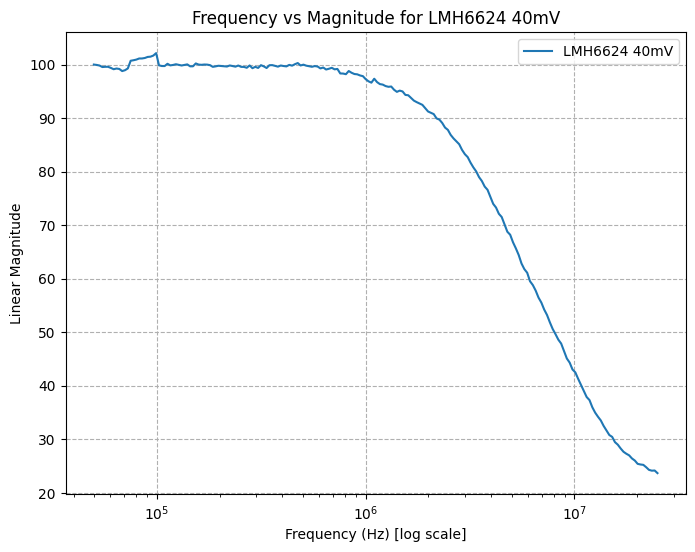

In [337]:
raw = False

source_folder_to_plot = 'LMH6624'  # Replace with folder name
source_file_to_plot = 'LMH6624_40mV'  # Replace with file name
plot_frequency_vs_linear_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)
